In [ ]:
pip install transformers

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from transformers import pipeline
from transformers import BertModel, BertTokenizer

import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')
data_address = '/content/drive/My Drive/NLU/Project/Datasets/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def probability_cal(input_name, aug_method):
  ori_data = pd.read_csv(data_address + input_name)
  aug_data = pd.read_csv(data_address + '/aug_' + aug_method + "/" +input_name)

  model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
  tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

  cos = torch.nn.CosineSimilarity(dim=0)
  column_name = ori_data.columns.values[0]

  probability_list = []
  for i in range(len(ori_data)):
    with torch.no_grad():
      embedding_ori = model(**tokenizer(ori_data[column_name][i], return_tensors="pt",truncation=True))[2][-2][0]
      embedding_aug = model(**tokenizer(aug_data[column_name][i], return_tensors="pt",truncation=True))[2][-2][0]

    sentence_emb_ori = torch.mean(embedding_ori, dim=0)
    sentence_emb_aug = torch.mean(embedding_aug, dim=0)

    probability = cos(sentence_emb_ori,sentence_emb_aug)
    probability_list.append(float(probability))

  return (probability_list)



def save_prob(input_name,aug_method,prob):
  ori_data = pd.read_csv(data_address + input_name)
  aug_data = pd.read_csv(data_address + '/aug_' + aug_method + "/" +input_name)

  column_name = ori_data.columns.values[0]
  label = ori_data.columns.values[-1]

  s1 = pd.Series(prob, name='probability')
  df = pd.concat([ori_data[column_name], aug_data[column_name], ori_data["label"], s1], axis=1, sort=False)
  df.columns = ["ori_"+column_name, "aug_"+ column_name, "label", "probability"]
  
  df.to_csv(data_address + '/aug_' + aug_method + "/prob_" +input_name, index = None, encoding = 'utf8')



def p_line(input_name,aug_method):
  prob = probability_cal(input_name,aug_method)
  save_prob(input_name,aug_method,prob)
  print("Average Similarity of " + aug_method + " " + input_name[:-4] + ": " + str(np.mean(prob))) 



def kde(aug_method):
  data_list = ["agnews_test.csv","imdb_test.csv","snli_test.csv"]
  color_list = ["black","red","blue"]
  line_list = ['-','--',':']
  plt.style.use('seaborn-deep')

  if type(aug_method) == str:
    for i in range(0,len(data_list)):
      data_name = data_list[i]
      df = pd.read_csv(data_address + '/aug_' + aug_method + "/prob_" + data_name)
      prob = df["probability"].tolist()
      sns.distplot(prob, hist=False, kde=False, fit=stats.norm, fit_kws={'color':color_list[i],'label':data_name[:data_name.find("_")].upper(),'linestyle':"-"})
  
  elif type(aug_method) == list:
    for i in range(0,len(data_list)):
      data_name = data_list[i]
      df1 = pd.read_csv(data_address + '/aug_' + aug_method[0] + "/prob_" + data_name)
      prob1 = df1["probability"].tolist()
      sns.distplot(prob1, hist=False, kde=False, fit=stats.norm, fit_kws={'color':color_list[i],'label':data_name[:data_name.find("_")].upper()+"_"+aug_method[0],'linestyle':"-"})

      df2 = pd.read_csv(data_address + '/aug_' + aug_method[1] + "/prob_" + data_name)
      prob2 = df2["probability"].tolist()
      sns.distplot(prob2, hist=False, kde=False, fit=stats.norm, fit_kws={'color':color_list[i],'label':data_name[:data_name.find("_")].upper()+"_"+aug_method[1],'linestyle':":"})
  
  plt.legend()
  plt.show()

In [ ]:
for i in ["agnews_test.csv","imdb_test.csv","snli_test.csv"]:
  #p_line(i,"weak_synonym")
  #p_line(i,"weak_random")
  p_line(i,"eda")
  p_line(i,"a2t")

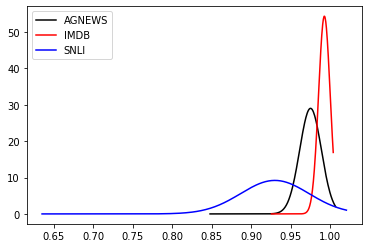

In [ ]:
kde("weak_random")

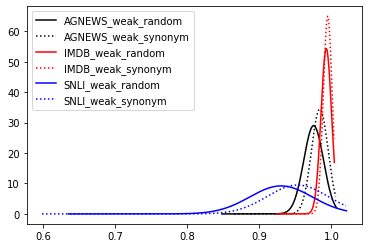

In [ ]:
kde(["weak_random","weak_synonym"])

Average Similarity of agnews_synonym:  0.9838367168919037
Average Similarity of imdb_synonym:  0.9948162700772285
Average Similarity of snli_synonym:  0.9530042693844059


In [ ]:
## Function Test

In [ ]:
#Bert output layer distance
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased")

distance = []
for i in range(len(test1)):
  encoded_input1 = tokenizer(test1["text"][i], return_tensors='pt')
  output1 = model(**encoded_input1)
  encoded_input2 = tokenizer(test2["text"][i], return_tensors='pt')
  output2 = model(**encoded_input2)
  distance.append(torch.cdist(output1[1], output2[1])**2)

In [ ]:
#Test distance using spacy
import spacy
nlp = spacy.load('en_core_web_sm')
print (nlp(test1["text"][2]).similarity(nlp(test2["text"][2]))) # 0.999999954642

0.9833415189786808


/usr/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)


In [ ]:
#Sentiment-analysis similarity 
from transformers import pipeline

def cal_senti_simi(input_name, aug_method):
  sentiment_pipeline = pipeline("sentiment-analysis")
  ori_data = pd.read_csv(data_address + input_name)
  aug_data = pd.read_csv(data_address + 'aug_' + aug_method + "_" +input_name)
  #aug_data = pd.read_csv(data_address + '/augmented_' + aug_method + "/" +input_name)

  column_name1 = ori_data.columns.values[0]
  if column_name1 == "text":
    senti_ori = sentiment_pipeline(list(ori_data["text"]),truncation=True)
    senti_aug = sentiment_pipeline(list(aug_data["text"]),truncation=True)

  else:
    senti_ori = sentiment_pipeline(list(ori_data[column_name1]),truncation=True)
    senti_aug = sentiment_pipeline(list(aug_data[column_name1]),truncation=True)
  
  #senti_list_ori = []
  #senti_list_aug = []

  count = 0
  pro_match_pair = []
  pro_mismatch_pair = []
  for i in range(len(ori_data)):
    if senti_ori[i]["label"] == senti_aug[i]["label"]:
      count +=1
      pro_match_pair.append(senti_aug[i]["score"])
    else:
      pro_mismatch_pair.append(senti_aug[i]["score"])

  similarity = count/len(ori_data)
    #senti_list_ori.append(senti_ori["label"])
    #senti_list_aug.append(senti_aug["label"])
  return similarity, pro_match_pair, pro_mismatch_pair

In [ ]:
senti_simi_agnews_test_synonym = cal_senti_simi("agnews_test.csv","synonym")
print("Similarity of agnews_synonym: ", senti_simi_agnews_test_synonym[0])
sns.distplot(senti_simi_agnews_test_synonym[1], rug=False, hist=False)

senti_simi_imdb_test_synonym = cal_senti_simi("imdb_test.csv","synonym")
print("Similarity of imdb_synonym: ", senti_simi_imdb_test_synonym[0])
sns.distplot(senti_simi_imdb_test_synonym[1], rug=False, hist=False)

senti_simi_snli_test_synonym = cal_senti_simi("snli_test.csv","synonym")
print("Similarity of snli_synonym: ", senti_simi_snli_test_synonym[0])
sns.distplot(senti_simi_snli_test_synonym[1], rug=False, hist=False)

In [ ]:
senti_simi_agnews_test_random = cal_senti_simi("agnews_test.csv","random")
print("Similarity of agnews_random: ", senti_simi_agnews_test_random[0])
sns.distplot(senti_simi_agnews_test_random[1], rug=False, hist=False)

senti_simi_imdb_test_random = cal_senti_simi("imdb_test.csv","random")
print("Similarity of imdb_random: ", senti_simi_imdb_test_random[0])
sns.distplot(senti_simi_imdb_test_random[1], rug=False, hist=False)

senti_simi_snli_test_random = cal_senti_simi("snli_test.csv","random")
print("Similarity of snli_random: ", senti_simi_snli_test_random[0])
sns.distplot(senti_simi_snli_test_random[1], rug=False, hist=False)

Similarity of agnews_random:  0.9322368421052631
Similarity of imdb_random:  0.9714
Similarity of snli_random:  0.8967833876221498
